# Plots and Tables

## Importing Results

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np

from utils import make_test_set_esnli, make_test_set_mnli

# Global variables
NUM_EXPL = 100
MODEL_NAMES = ['xsmall', 'small', 'base', 'large']
DATASETS = ['mnli', 'esnli', 'cose']
DATASETS_NLI = ['esnli', 'mnli']
DATASET_LABELS = ['MNLI', 'e-SNLI', 'CoS-e']
DATASET_NLI_LABELS = ['MNLI', 'e-SNLI']
DATASETS_IOU = ['esnli', 'cose']
DATASETS_IOU_LABELS = ['e-SNLI', 'CoS-e']
DATASET_COLORS = ['tab:blue', 'tab:green', 'tab:red']
LINESTYLES = ['-', '--', ':']



dataset_esnli = make_test_set_esnli(size=NUM_EXPL) # 9830 is dev size esnli (originally 9842 but 12 instance are wrongly annotated)
dataset_mnli = make_test_set_mnli(size=NUM_EXPL) # 9815 is dev size mnli
datasets_nli_data = (dataset_esnli, dataset_mnli)

# Importing results calculated on Colab servers

# Read the files
with open('results/json/explainability_results_mnli.json', 'r') as f:
    explainability_results_mnli = json.load(f)

with open('results/json/explainability_results_esnli.json', 'r') as f:
    explainability_results_esnli = json.load(f)

with open('results/json/explainability_results_cose_wo_large.json', 'r') as f:
    explainability_results_cose_wo_large = json.load(f)

with open('results/json/explainability_results_cose_large.json', 'r') as f:
    explainability_results_cose_large = json.load(f)

with open('results/json/predictions_for_explanations.json', 'r') as f:
    predictions_for_explanations = json.load(f)

with open('results/json/results.json', 'r') as f:
    results = json.load(f)

with open('results/json/confidence_intervals.json', 'r') as f:
    confidence_intervals = json.load(f)

# Merging cose results
explainability_results_cose = explainability_results_cose_wo_large
explainability_results_cose['cose']['large'] = explainability_results_cose_large['cose']['large']

# all in one dictionary:
explainability_results = {}
explainability_results['mnli'] = explainability_results_mnli['mnli']
explainability_results['esnli'] = explainability_results_esnli['esnli']
explainability_results['cose'] = explainability_results_cose['cose']


def print_key_tree(d, indent=0):
    for key, value in d.items():
        print('  ' * indent + str(key) + ": " + str(type(value)))
        if isinstance(value, dict):
            print_key_tree(value, indent + 1)
        elif isinstance(value, list):
            if all(isinstance(i, dict) for i in value):
                for sub_dict in value:
                    print_key_tree(sub_dict, indent + 1)

## Indexing results by label and prediction correctness

In [2]:
# Indices by labels
for j, dataset in enumerate(DATASETS_NLI):
    contradiction_idx = [i for i in range(NUM_EXPL) if datasets_nli_data[j]['test_labels_text'][i] == 'contradiction']
    entailment_idx = [i for i in range(NUM_EXPL) if datasets_nli_data[j]['test_labels_text'][i] == 'entailment']
    neutral_idx = [i for i in range(NUM_EXPL) if datasets_nli_data[j]['test_labels_text'][i] == 'neutral']
    explainability_results[dataset]['indices'] = {'contradiction_idx': contradiction_idx, 'entailment_idx': entailment_idx, 'neutral_idx': neutral_idx}

# Indices by correct predicition
for dataset in DATASETS:
    for model_name in MODEL_NAMES:
        explainability_results[dataset][model_name]['correct_idx'] = [True if predictions_for_explanations[dataset]['true'][i] == predictions_for_explanations[dataset][model_name]['pred'][i] else False for i in range(NUM_EXPL)]

# standard error of the mean 
def get_sem(list): 
    std_dev = np.std(list)
    n = len(list)
    return std_dev / np.sqrt(n)

# splitting by label
for dataset in ['mnli', 'esnli']:
    for model_name in MODEL_NAMES:
        comp = explainability_results[dataset][model_name]['faithfulness']['comprehensiveness']
        for label in ['contradiction', 'entailment', 'neutral']:
            explainability_results[dataset][model_name]['faithfulness']['comp_' + label] = [comp[i] for i in explainability_results[dataset]['indices'][label + '_idx']]
        
# splitting by prediction
for dataset in DATASETS:
    for model_name in MODEL_NAMES:
        explainability_results[dataset][model_name]['faithfulness']['sem_comp'] = get_sem(explainability_results[dataset][model_name]['faithfulness']['comprehensiveness'])
        if dataset != 'mnli':
            explainability_results[dataset][model_name]['plausibility']['sem_iou'] = get_sem(explainability_results[dataset][model_name]['plausibility']['iou'])


In [3]:
# Uncomment to print the structure of the explainability_results dictionary
# print_key_tree(explainability_results)

## Accuracy, Comprehensiveness and IOU scores

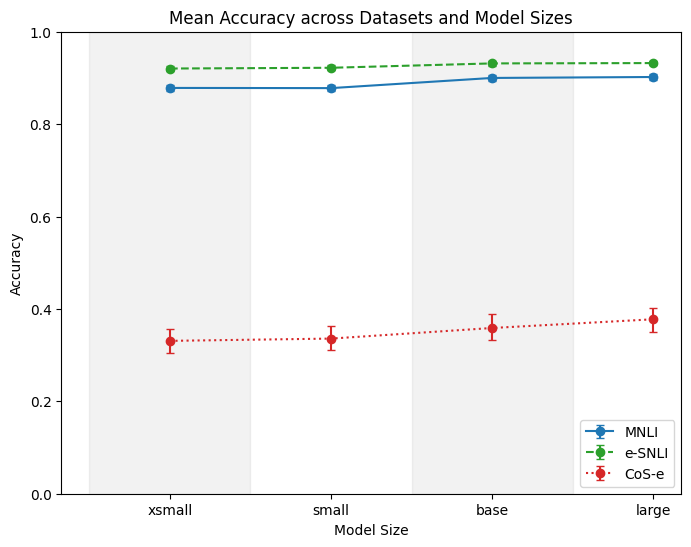

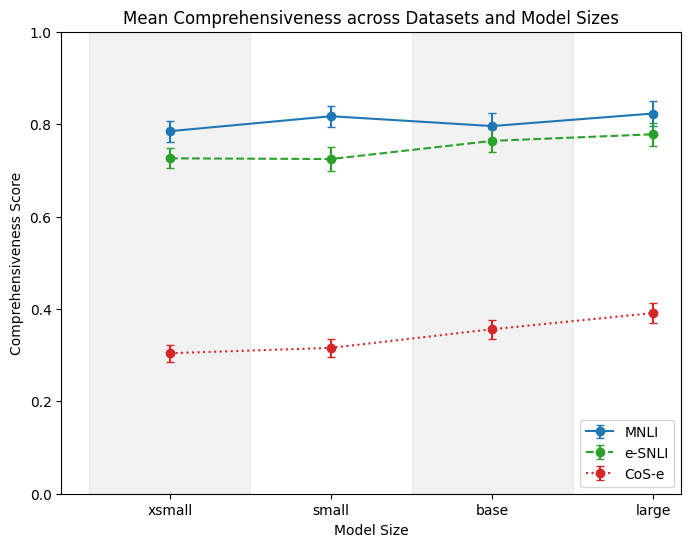

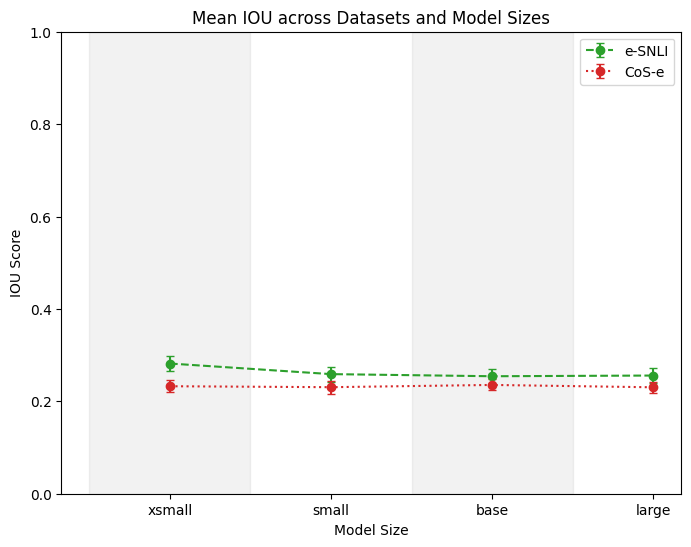

In [4]:
# Plotting function. Plots 'comprehensiveness' by default, can be set to 'IOU'
def plot(metric='Comprehensiveness'):
    plt.figure(figsize=(8, 6))
    
    if metric in ['Comprehensiveness', 'IOU']:
        if metric == 'Comprehensiveness':
            metric_key = 'faithfulness'
            sem_key = 'sem_comp'
        elif metric == 'IOU':
            metric_key = 'plausibility'
            sem_key = 'sem_iou'

        for i, dataset, label, color in zip(range(3), DATASETS, DATASET_LABELS, DATASET_COLORS):
            if dataset == 'mnli' and metric == 'IOU':
                continue
            y_values = [explainability_results[dataset][model_name][metric_key][f'macro_{metric.lower()}'] for model_name in MODEL_NAMES]
            y_errors = [explainability_results[dataset][model_name][metric_key][sem_key] for model_name in MODEL_NAMES]
            plt.errorbar(MODEL_NAMES, y_values, yerr=y_errors, label=f'{label}', capsize=3, marker='o', color=color, linestyle=LINESTYLES[i])

        plt.ylabel(f'{metric} Score')

    elif metric == 'Accuracy':
        # Iterate through each dataset
        for i, dataset, color in zip(range(3), DATASETS, DATASET_COLORS):
            dataset_results = results[dataset]
            accuracies = [dataset_results[model]['accuracy'] for model in MODEL_NAMES]
            # Extract confidence intervals for the dataset and models
            conf_intervals = [confidence_intervals[dataset][model]['accuracy'] for model in MODEL_NAMES]
            # Separate the lower and upper bounds of the confidence intervals
            lower_bounds = [acc - lower for acc, (lower, upper) in zip(accuracies, conf_intervals)]
            upper_bounds = [upper - acc for acc, (lower, upper) in zip(accuracies, conf_intervals)]
            # Plot with error bars
            plt.errorbar(MODEL_NAMES, accuracies, yerr=[lower_bounds, upper_bounds], label=DATASET_LABELS[i], capsize=3, marker='o', color=color, linestyle=LINESTYLES[i])

        plt.ylabel("Accuracy")

    plt.ylim(0, 1)
    plt.xlabel('Model Size')
    plt.title(f'Mean {metric} across Datasets and Model Sizes')
    plt.xticks(ticks=np.arange(len(MODEL_NAMES)), labels=MODEL_NAMES)  # Set x-tick labels to model names
    
    # Add shadowed background for each category
    for i in range(0, len(MODEL_NAMES), 2):
        plt.axvspan(i - 0.5, i + 0.5, color='gray', alpha=0.1)
    
    plt.legend(loc='best')
    plt.show()

plot(metric='Accuracy')
plot(metric='Comprehensiveness')
plot(metric='IOU')

## Comprehensiveness by Label and Prediction

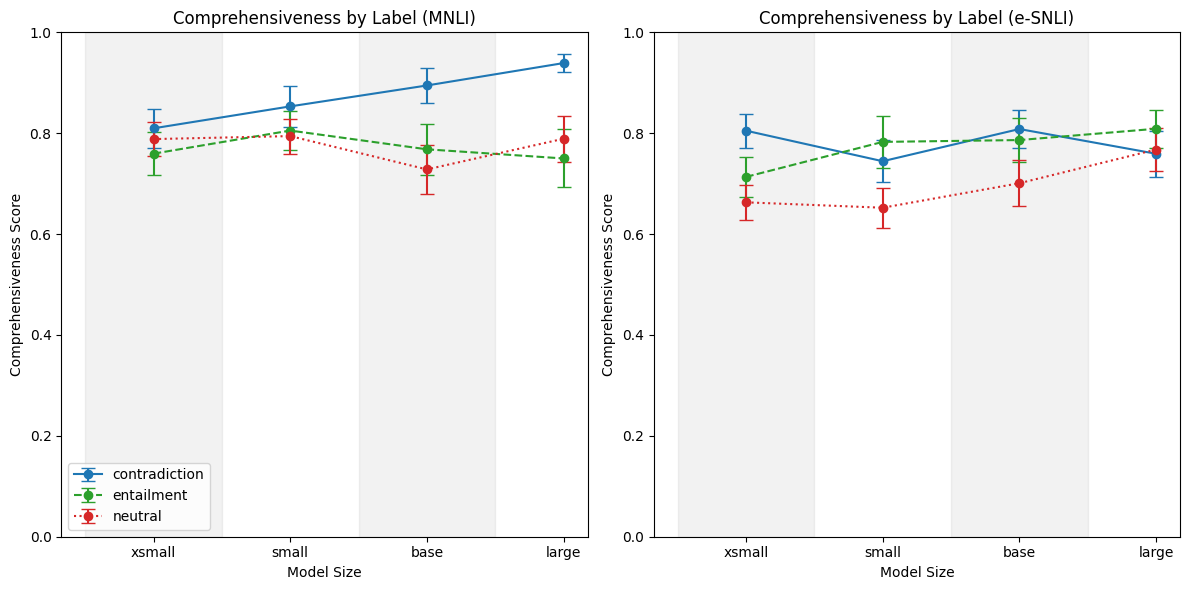

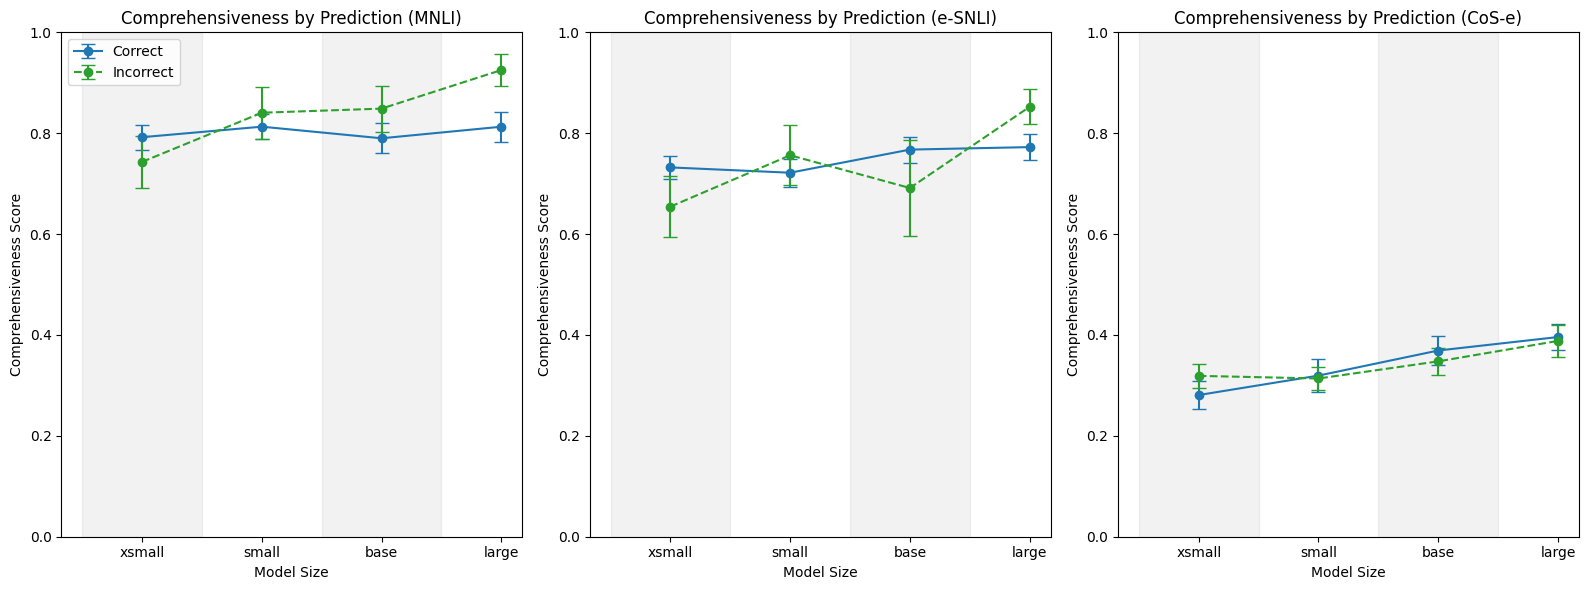

In [5]:
# Function to get Standard Error of the Mean
def get_sem(data_list):
    return np.std(data_list) / np.sqrt(len(data_list))

# Function to add shadowed background for model size
def add_shadowed_background(ax, MODEL_NAMES):
    for j, _ in enumerate(MODEL_NAMES):
        if j % 2 == 0:
            ax.axvspan(j-0.5, j+0.5, color='gray', alpha=0.1)

# Function to plot comprehensiveness
def plot_comprehensiveness(by='label'):
    colors = {'label': ['tab:blue', 'tab:green', 'tab:red'], 'prediction': ['tab:blue', 'tab:green']}
    labels = {'label': ['contradiction', 'entailment', 'neutral'], 'prediction': ['Correct', 'Incorrect']}
    
    plt.figure(figsize=(12 if by == 'label' else 16, 6))
    
    for i, (dataset_key, dataset_name) in enumerate(zip(DATASETS, DATASET_LABELS)):
        if by == 'label' and dataset_key == 'cose':  # Skip CoS-e for label plots
            continue
        
        ax = plt.subplot(1, 2 if by == 'label' else 3, i+1)
        
        for j, label in enumerate(labels[by]):
            means, sems = [], []
            
            for model_name in MODEL_NAMES:
                if by == 'label':
                    data = explainability_results[dataset_key][model_name]['faithfulness'][f'comp_{label}']
                else:  # by == 'prediction'
                    comp = np.array(explainability_results[dataset_key][model_name]['faithfulness']['comprehensiveness'])  # Convert to NumPy array for boolean indexing
                    idx = np.array(explainability_results[dataset_key][model_name]['correct_idx'])  # Ensure idx is a NumPy array
                    if label == 'Incorrect':
                        idx = np.logical_not(idx)
                    data = comp[idx]
                
                means.append(np.mean(data))
                sems.append(get_sem(data))
            
            ax.errorbar(np.arange(len(MODEL_NAMES)), means, yerr=sems, marker='o', color=colors[by][j], label=label, capsize=5, linestyle=LINESTYLES[j])
        
        add_shadowed_background(ax, MODEL_NAMES)
        ax.set_ylim(0, 1)
        ax.set_xlabel('Model Size')
        ax.set_ylabel('Comprehensiveness Score')
        ax.set_title(f'Comprehensiveness by {by.capitalize()} ({dataset_name})')
        ax.set_xticks(np.arange(len(MODEL_NAMES)))
        ax.set_xticklabels(MODEL_NAMES)
        
        if i == 0:
            ax.legend()

    plt.tight_layout()
    plt.show()


# Example usage:
plot_comprehensiveness(by='label')
plot_comprehensiveness(by='prediction')


## IOU by Label and Prediction

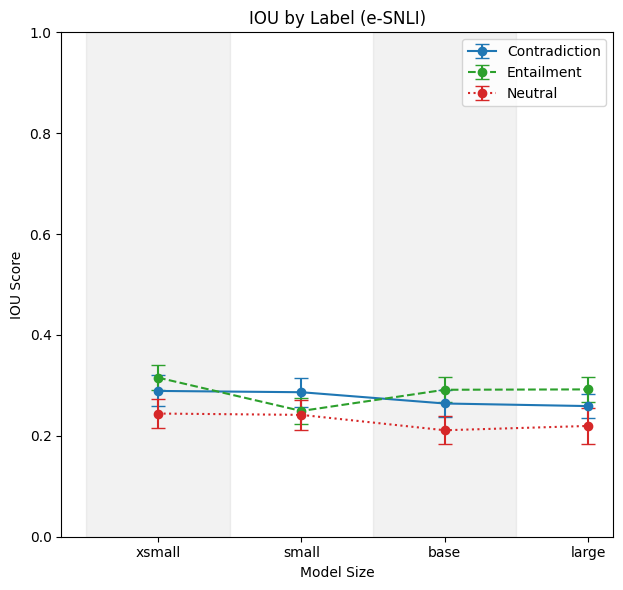

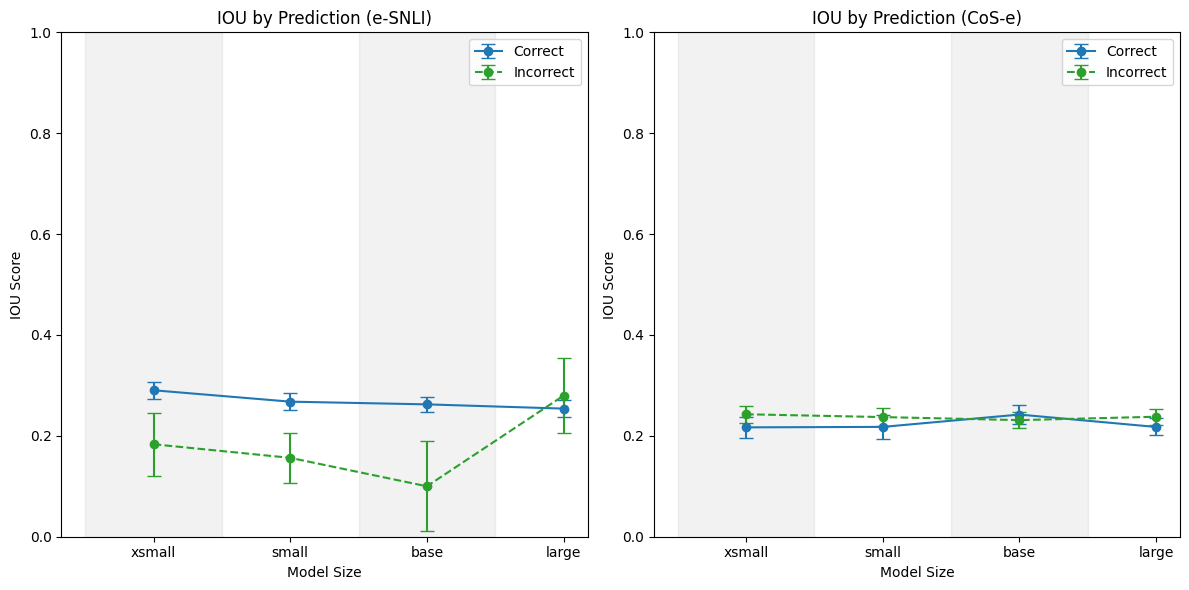

In [6]:
def plot_iou(by='label'):
    colors = {'label': ['tab:blue', 'tab:green', 'tab:red'], 'prediction': ['tab:blue', 'tab:green']}
    labels = {'label': ['Contradiction', 'Entailment', 'Neutral'], 'prediction': ['Correct', 'Incorrect']}
    
    plt.figure(figsize=(12, 6))
    
    for i, dataset_key in enumerate(DATASETS_IOU):
        # Handle the dataset-specific conditions for plotting
        if by == 'label' and dataset_key != 'esnli':
            continue
        if by == 'prediction' and dataset_key not in ['esnli', 'cose']:
            continue

        ax = plt.subplot(1, 2, i+1)
        
        for j, label in enumerate(labels[by]):
            means, sems = [], []
            
            for model_name in MODEL_NAMES:
                iou = np.array(explainability_results[dataset_key][model_name]['plausibility']['iou'])
                if by == 'label':
                    if dataset_key == 'esnli': # only e-SNLI has has iou scores by label
                        label_indices = np.array(explainability_results[dataset_key]['indices'][f'{label.lower()}_idx'])
                        data = iou[label_indices]
                else:  # by == 'prediction'
                    correct_idx = np.array(explainability_results[dataset_key][model_name]['correct_idx'])
                    if label == 'Incorrect':
                        correct_idx = np.logical_not(correct_idx)
                    data = iou[correct_idx]
                
                means.append(np.mean(data))
                sems.append(get_sem(data))
            
            # Proceed with plotting only if there are data points to plot
            if means:
                ax.errorbar(np.arange(len(MODEL_NAMES)), means, yerr=sems, marker='o', color=colors[by][j], label=label, capsize=5, linestyle=LINESTYLES[j])
            
        add_shadowed_background(ax, MODEL_NAMES)
        ax.set_ylim(0, 1)
        ax.set_xlabel('Model Size')
        ax.set_ylabel('IOU Score')
        ax.set_title(f'IOU by {by.capitalize()} ({DATASETS_IOU_LABELS[i]})')
        ax.set_xticks(np.arange(len(MODEL_NAMES)))
        ax.set_xticklabels(MODEL_NAMES)
        
        if i == 0 or (by == 'prediction' and i == 1):  # Adjust legend placement
            ax.legend()
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_iou(by='label')
plot_iou(by='prediction')


# Tables

In [7]:
import pandas as pd

# Initialize data list
data = []

# Loop through datasets and model names to populate the data list
for dataset, label in zip(DATASETS, DATASET_LABELS):
    for model_name in MODEL_NAMES:
        macro_comprehensiveness = round(explainability_results[dataset][model_name]['faithfulness']['macro_comprehensiveness'], 3)
        sem_comp = round(explainability_results[dataset][model_name]['faithfulness']['sem_comp'], 3)
        
        macro_sufficiency = round(explainability_results[dataset][model_name]['faithfulness']['macro_sufficiency'], 3)
        
        if dataset == 'mnli':
            macro_iou = '-'
            sem_iou = '-'
        else:
            macro_iou = round(explainability_results[dataset][model_name]['plausibility']['macro_iou'], 3)
            sem_iou = round(explainability_results[dataset][model_name]['plausibility']['sem_iou'], 3)
        
        # Create strings with macro scores and SEM
        comp_str = f"{macro_comprehensiveness} (+- {sem_comp})"
        iou_str = f"{macro_iou} (+- {sem_iou})" if macro_iou != '-' else '-'
        
        # Append to data list
        data.append([label, model_name, comp_str, iou_str])


# Create DataFrame
df_explainability_results = pd.DataFrame(data, columns=['Dataset', 'Model Size', 'Macro Comprehensiveness', 'Macro IOU'])

# Display DataFrame
df_explainability_results.head(50)



,Dataset,Model Size,Macro Comprehensiveness,Macro IOU
0,MNLI,xsmall,0.785 (+- 0.022),-
1,MNLI,small,0.817 (+- 0.022),-
2,MNLI,base,0.796 (+- 0.027),-
3,MNLI,large,0.823 (+- 0.027),-
4,e-SNLI,xsmall,0.726 (+- 0.022),0.282 (+- 0.017)
5,e-SNLI,small,0.724 (+- 0.026),0.259 (+- 0.016)
6,e-SNLI,base,0.764 (+- 0.025),0.254 (+- 0.016)
7,e-SNLI,large,0.778 (+- 0.025),0.256 (+- 0.017)
8,CoS-e,xsmall,0.304 (+- 0.018),0.233 (+- 0.013)
9,CoS-e,small,0.316 (+- 0.019),0.231 (+- 0.014)


In [8]:
df_explainability_results.to_csv('results/tables/df_explainability_results.csv', index=False)

In [9]:
# Initialize empty lists to hold our data
dataset_list = []
model_size_list = []
label_list = []
comprehensiveness_list = []

# Loop through each dataset (MNLI and e-SNLI)
for dataset in ['mnli', 'esnli']:
    # Loop through each model size (xsmall, small, base, large)
    for model_size in ['xsmall', 'small', 'base', 'large']:
        # Loop through each label (contradiction, entailment, neutral)
        for label in ['contradiction', 'entailment', 'neutral']:
            dataset_list.append(dataset.upper())
            model_size_list.append(model_size)
            label_list.append(label)
            
            # Extract the mean values and SEM for comprehensiveness and sufficiency for each label
            comp_key = f'comp_{label}'            
            mean_comp = np.mean(explainability_results[dataset][model_size]['faithfulness'][comp_key])
            sem_comp = get_sem(explainability_results[dataset][model_size]['faithfulness'][comp_key])
            
            # Create strings with mean values and SEM
            comp_str = f"{mean_comp:.3f} (+- {sem_comp:.3f})"
            
            comprehensiveness_list.append(comp_str)

# Create the DataFrame
df_faithfulness_nli_by_label = pd.DataFrame({
    'Dataset': dataset_list,
    'Model Size': model_size_list,
    'Label': label_list,
    'Comprehensiveness': comprehensiveness_list,
})

# Show the DataFrame
df_faithfulness_nli_by_label.head(30)


,Dataset,Model Size,Label,Comprehensiveness
0,MNLI,xsmall,contradiction,0.810 (+- 0.038)
1,MNLI,xsmall,entailment,0.759 (+- 0.042)
2,MNLI,xsmall,neutral,0.788 (+- 0.034)
3,MNLI,small,contradiction,0.853 (+- 0.041)
4,MNLI,small,entailment,0.805 (+- 0.039)
5,MNLI,small,neutral,0.794 (+- 0.035)
6,MNLI,base,contradiction,0.895 (+- 0.034)
7,MNLI,base,entailment,0.768 (+- 0.050)
8,MNLI,base,neutral,0.728 (+- 0.049)
9,MNLI,large,contradiction,0.939 (+- 0.018)


In [10]:
df_faithfulness_nli_by_label.to_csv('results/tables/df_faithfulness_nli_by_label.csv', index=False)

In [11]:
# Initialize an empty list to store rows of the DataFrame
data = []

# Loop through each dataset
for dataset in DATASETS:
    # Loop through each model size
    for model_size in MODEL_NAMES:
        # Extract the relevant data
        comp = np.array(explainability_results[dataset][model_size]['faithfulness']['comprehensiveness'])
        correct_idx = np.array(explainability_results[dataset][model_size]['correct_idx'])
        
        # Calculate the means and SEM for correct and incorrect predictions
        comp_correct_mean = np.mean(comp[correct_idx])
        comp_correct_sem = get_sem(comp[correct_idx])
        
        comp_incorrect_mean = np.mean(comp[~correct_idx])
        comp_incorrect_sem = get_sem(comp[~correct_idx])
        
        # Create strings with mean values and SEM
        comp_correct_str = f"{comp_correct_mean:.3f} (+- {comp_correct_sem:.3f})"
        comp_incorrect_str = f"{comp_incorrect_mean:.3f} (+- {comp_incorrect_sem:.3f})"
        
        # Append the data to the list
        data.append([dataset.upper(), model_size, 'Correct', comp_correct_str])
        data.append([dataset.upper(), model_size, 'Incorrect', comp_incorrect_str])

# Create the DataFrame
df_faithfulness_by_prediction = pd.DataFrame(data, columns=['Dataset', 'Model_Size', 'Prediction_Status', 'Comprehensiveness'])

# Show the DataFrame
df_faithfulness_by_prediction.head(50)


,Dataset,Model_Size,Prediction_Status,Comprehensiveness
0,MNLI,xsmall,Correct,0.792 (+- 0.025)
1,MNLI,xsmall,Incorrect,0.743 (+- 0.051)
2,MNLI,small,Correct,0.813 (+- 0.025)
3,MNLI,small,Incorrect,0.841 (+- 0.052)
4,MNLI,base,Correct,0.790 (+- 0.030)
5,MNLI,base,Incorrect,0.849 (+- 0.045)
6,MNLI,large,Correct,0.813 (+- 0.030)
7,MNLI,large,Incorrect,0.925 (+- 0.032)
8,ESNLI,xsmall,Correct,0.732 (+- 0.023)
9,ESNLI,xsmall,Incorrect,0.654 (+- 0.061)


In [12]:
df_faithfulness_by_prediction.to_csv('results/tables/df_faithfulness_by_prediction.csv', index=False)

In [13]:
# Initialize an empty list to store rows of the DataFrame
data_plausibility = []

# Loop through each dataset (only e-SNLI and CoS-e)
for dataset in ['esnli', 'cose']:
    # Loop through each model size
    for model_size in MODEL_NAMES:
        # Extract the relevant data
        iou = np.array(explainability_results[dataset][model_size]['plausibility']['iou'])
        correct_idx = np.array(explainability_results[dataset][model_size]['correct_idx'])
        
        # Calculate the means and SEMs for correct and incorrect predictions
        iou_correct_mean = np.mean(iou[correct_idx])
        iou_correct_sem = get_sem(iou[correct_idx])
        iou_incorrect_mean = np.mean(iou[~correct_idx])
        iou_incorrect_sem = get_sem(iou[~correct_idx])
        
        # Format the mean and SEM values into strings
        iou_correct_str = f"{iou_correct_mean:.3f} (+- {iou_correct_sem:.3f})"
        iou_incorrect_str = f"{iou_incorrect_mean:.3f} (+- {iou_incorrect_sem:.3f})"
        
        # Append the data to the list
        data_plausibility.append([dataset.upper(), model_size, 'Correct', iou_correct_str])
        data_plausibility.append([dataset.upper(), model_size, 'Incorrect', iou_incorrect_str])

# Create the DataFrame
df_plausibility_by_prediction = pd.DataFrame(data_plausibility, columns=['Dataset', 'Model_Size', 'Prediction_Status', 'IoU'])

# Show the DataFrame
df_plausibility_by_prediction.head(50)


,Dataset,Model_Size,Prediction_Status,IoU
0,ESNLI,xsmall,Correct,0.290 (+- 0.017)
1,ESNLI,xsmall,Incorrect,0.183 (+- 0.063)
2,ESNLI,small,Correct,0.268 (+- 0.017)
3,ESNLI,small,Incorrect,0.156 (+- 0.049)
4,ESNLI,base,Correct,0.262 (+- 0.016)
5,ESNLI,base,Incorrect,0.100 (+- 0.089)
6,ESNLI,large,Correct,0.254 (+- 0.018)
7,ESNLI,large,Incorrect,0.280 (+- 0.074)
8,COSE,xsmall,Correct,0.217 (+- 0.021)
9,COSE,xsmall,Incorrect,0.243 (+- 0.017)


In [14]:
df_plausibility_by_prediction.to_csv('results/tables/df_plausibility_by_prediction.csv', index=False)

In [15]:
# Initialize empty lists to hold our data
dataset_list = []
model_size_list = []
label_list = []
iou_list = []
tokenf1_list = []

# Loop through each model size (xsmall, small, base, large)
for model_size in MODEL_NAMES:
    # Loop through each label (Contradiction, Entailment, Neutral)
    for label in ['Contradiction', 'Entailment', 'Neutral']:
        dataset_list.append('e-SNLI')
        model_size_list.append(model_size)
        label_list.append(label)
        
        # Extract the mean values and SEM for IoU and TokenF1 for each label
        iou = np.array(explainability_results['esnli'][model_size]['plausibility']['iou'])

        label_idx = np.array(explainability_results['esnli']['indices'][f'{label.lower()}_idx'])
        
        mean_iou = np.mean(iou[label_idx])
        sem_iou = get_sem(iou[label_idx])
        
        # Format the mean and SEM values into strings
        iou_str = f"{mean_iou:.3f} (+- {sem_iou:.3f})"
        
        iou_list.append(iou_str)

# Create the DataFrame
df_plausibility_by_label = pd.DataFrame({
    'Dataset': dataset_list,
    'Model Size': model_size_list,
    'Label': label_list,
    'IoU': iou_list,
})

# Show the DataFrame
df_plausibility_by_label.head(12)


,Dataset,Model Size,Label,IoU
0,e-SNLI,xsmall,Contradiction,0.289 (+- 0.031)
1,e-SNLI,xsmall,Entailment,0.315 (+- 0.025)
2,e-SNLI,xsmall,Neutral,0.244 (+- 0.028)
3,e-SNLI,small,Contradiction,0.286 (+- 0.029)
4,e-SNLI,small,Entailment,0.249 (+- 0.025)
5,e-SNLI,small,Neutral,0.242 (+- 0.030)
6,e-SNLI,base,Contradiction,0.264 (+- 0.027)
7,e-SNLI,base,Entailment,0.291 (+- 0.025)
8,e-SNLI,base,Neutral,0.211 (+- 0.028)
9,e-SNLI,large,Contradiction,0.259 (+- 0.024)


In [16]:
df_plausibility_by_label.to_csv('results/tables/df_plausibility_by_label.csv', index=False)

In [17]:
# Extract the data
label_data = []
prediction_data = []

for dataset in DATASETS:
    if dataset != 'cose':
        label_data.append({
            'Dataset': dataset,
            'Contradiction': len(explainability_results[dataset]['xsmall']['faithfulness']['comp_contradiction']),
            'Entailment': len(explainability_results[dataset]['xsmall']['faithfulness']['comp_entailment']),
            'Neutral': len(explainability_results[dataset]['xsmall']['faithfulness']['comp_neutral'])
        })
    
    for model_size in MODEL_NAMES:
        correct_count = sum(explainability_results[dataset][model_size]['correct_idx'])
        incorrect_count = 100 - correct_count
        prediction_data.append({
            'Dataset': dataset,
            'Model Size': model_size,
            'Correct': correct_count,
            'Incorrect': incorrect_count
        })

# Create the DataFrames
df_count_by_label = pd.DataFrame(label_data)
df_count_by_prediction = pd.DataFrame(prediction_data)

df_count_by_label.head()



,Dataset,Contradiction,Entailment,Neutral
0,mnli,32,36,32
1,esnli,33,32,35


In [18]:
df_count_by_label.to_csv('results/tables/df_count_by_label.csv', index=False)

In [19]:
df_count_by_prediction

,Dataset,Model Size,Correct,Incorrect
0,mnli,xsmall,85,15
1,mnli,small,85,15
2,mnli,base,90,10
3,mnli,large,91,9
4,esnli,xsmall,92,8
5,esnli,small,92,8
6,esnli,base,95,5
7,esnli,large,93,7
8,cose,xsmall,39,61
9,cose,small,34,66


In [20]:
df_count_by_prediction.to_csv('results/tables/df_count_by_prediction.csv', index=False)

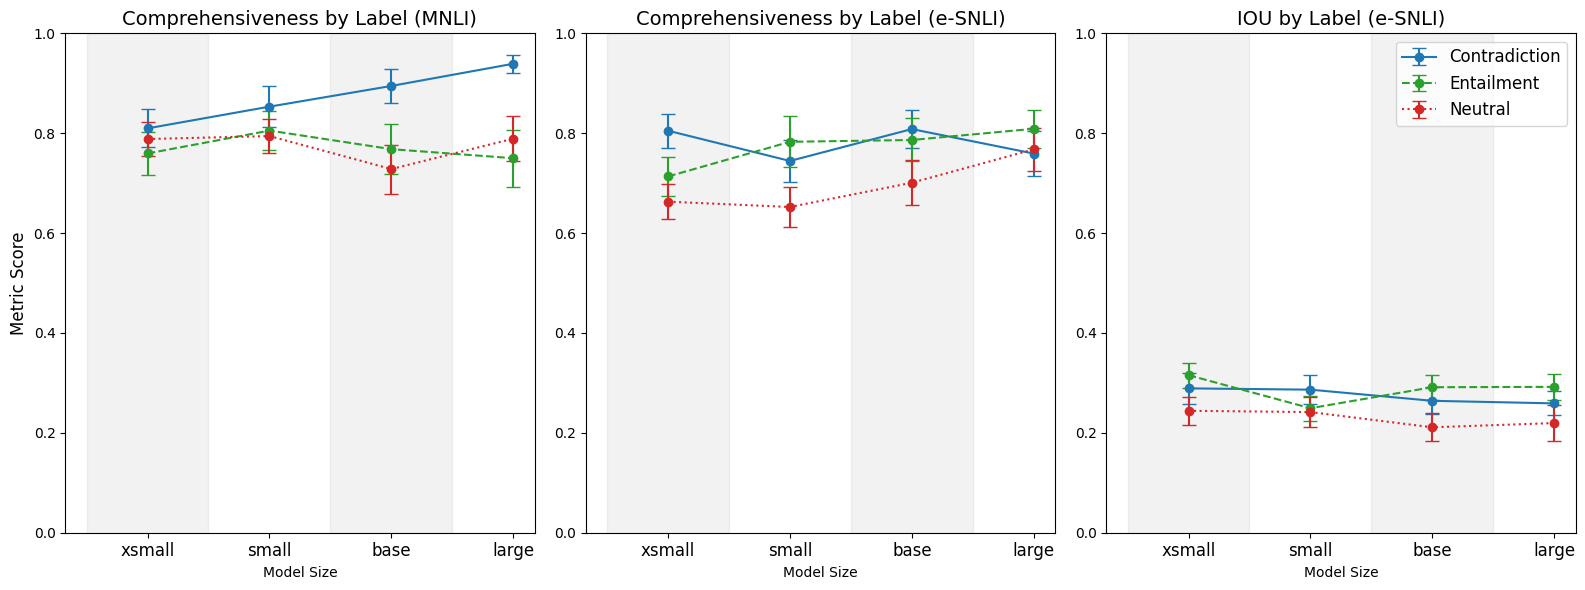

In [23]:
# For POSTER (all plots by label)

def plot_combined():
    fig, axes = plt.subplots(1, 3, figsize=(16, 6))  # 1 row, 3 columns
    linestyles = ['-', '--', ':']
    labels = {'label': ['contradiction', 'entailment', 'neutral']}
    colors = ['tab:blue', 'tab:green', 'tab:red']
    comprehensiveness_datasets = ['mnli', 'esnli']
    
    for i, dataset_key in enumerate(comprehensiveness_datasets):
        ax = axes[i]
        for j, label in enumerate(labels['label']):
            means, sems = [], []
            for model_name in MODEL_NAMES:
                data = explainability_results[dataset_key][model_name]['faithfulness'][f'comp_{label}']
                means.append(np.mean(data))
                sems.append(get_sem(data))
            ax.errorbar(np.arange(len(MODEL_NAMES)), means, yerr=sems, marker='o', linestyle=linestyles[j], label=label.capitalize(), capsize=5, color=colors[j])
        
        add_shadowed_background(ax, MODEL_NAMES)
        ax.set_ylim(0, 1)
        ax.set_title(f'Comprehensiveness by Label ({DATASET_NLI_LABELS[i]})', fontsize=14)
        if i == 0: ax.set_ylabel('Metric Score', fontsize=12)
        ax.set_xticks(np.arange(len(MODEL_NAMES)))
        ax.set_xticklabels(MODEL_NAMES, fontsize=12)
        ax.set_xlabel('Model Size')

    # Plotting IOU by Label for e-SNLI
    ax = axes[2]
    for j, label in enumerate(labels['label']):
        means, sems = [], []
        for model_name in MODEL_NAMES:
            iou = np.array(explainability_results['esnli'][model_name]['plausibility']['iou'])
            label_indices = np.array(explainability_results['esnli']['indices'][f'{label}_idx'])
            data = iou[label_indices]
            means.append(np.mean(data))
            sems.append(get_sem(data))
        ax.errorbar(np.arange(len(MODEL_NAMES)), means, yerr=sems, linestyle=linestyles[j], marker='o', label=label.capitalize(), capsize=5, color=colors[j])
    
    add_shadowed_background(ax, MODEL_NAMES)
    ax.set_ylim(0, 1)
    ax.set_title('IOU by Label (e-SNLI)', fontsize=14)
    ax.set_xticks(np.arange(len(MODEL_NAMES)))
    ax.set_xticklabels(MODEL_NAMES, fontsize=12)
    ax.set_xlabel('Model Size')
    ax.legend(fontsize=12)

    plt.tight_layout()
    plt.show()

plot_combined()
